<a href="https://colab.research.google.com/github/theresaxx/Financial-Disclosure-NLP-10K/blob/main/1_data_extraction_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Pipeline to extract SEC statements

By law it is required for some companies and securities are to publish quarterly 10-Q and an annual 10-K reports. These documents are public information, managed by the U.S. Securities and Exchange Commission (SEC) and accessible by the Electronic Data Gathering, Analysis, and Retriever system (EDGAR).
Website where the reports can be searched: https://www.sec.gov/edgar.shtml



1. Load company dataframe
2. Use secedgar package to call SEC API and get the ULRs
3. Scrape the filing date of the document 
4. Use Yahoo query to extract stock development and index developemnt and calulate relative development
5. Labeling of the dataframe
6. Parsing of the text items

#### Set up of the notebook

In [ ]:
#Declare whether you are on colab or local
colab = True

In [ ]:
if colab==True:
  
  #mount drive
  from google.colab import drive
  drive.mount('/content/drive')


  #set path to folder in Google Drive
  data_path = "/content/drive/MyDrive/Masterthesis/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### import + load libraries 

In [ ]:
#install packages
!pip install edgar
!pip install secedgar
!pip install yahooquery

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#import libraries 
import pandas as pd
import datetime
import numpy as np
import requests

from secedgar import filings, FilingType, CompanyFilings

from bs4 import BeautifulSoup,Comment
import re
import requests
import urllib
from yahooquery import Ticker

import csv

Accessing and retrieving the SEC EDGAR Data has followwing requirementsas documented on their website https://www.sec.gov/os/accessing-edgar-data

1. The SEC API allows a max request rate of 10 requests per second
2. Using the SEC API requires authentication with an email address in the User-Agent header of the HTTP requests to prove that the requests are not done by a robot


In [ ]:
import time
time.sleep(.1)

In [ ]:
headers = {'user-agent': 'theresa@gmail.com'}

### Load S&P 500 dataframe

In [ ]:
#loading the S&P companies into a pandas dataframe
table= pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
df = table[0]
df

,Symbol,Security,SEC filings,GICS Sector,GICS Sub-Industry,Headquarters Location,Date first added,CIK,Founded
0,MMM,3M,reports,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1976-08-09,66740,1902
1,AOS,A. O. Smith,reports,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
2,ABT,Abbott,reports,Health Care,Health Care Equipment,"North Chicago, Illinois",1964-03-31,1800,1888
3,ABBV,AbbVie,reports,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
4,ABMD,Abiomed,reports,Health Care,Health Care Equipment,"Danvers, Massachusetts",2018-05-31,815094,1981
...,...,...,...,...,...,...,...,...,...
498,YUM,Yum! Brands,reports,Consumer Discretionary,Restaurants,"Louisville, Kentucky",1997-10-06,1041061,1997
499,ZBRA,Zebra Technologies,reports,Information Technology,Electronic Equipment & Instruments,"Lincolnshire, Illinois",2019-12-23,877212,1969
500,ZBH,Zimmer Biomet,reports,Health Care,Health Care Equipment,"Warsaw, Indiana",2001-08-07,1136869,1927
501,ZION,Zions Bancorporation,reports,Financials,Regional Banks,"Salt Lake City, Utah",2001-06-22,109380,1873


In [ ]:
#add quotation marks to the column Symbol, which is necessary formal requirement when calling the API 
#Replace "." with "-" from Symbols (BRK.B -> BRK-B, BF.B -> BF-B)

df['Symbol'] = df['Symbol'].apply(lambda x: "'" + str(x) + "'")
df['Symbol']  = df['Symbol'].apply(lambda x: x.replace('.','-'))
df.head()

,Symbol,Security,SEC filings,GICS Sector,GICS Sub-Industry,Headquarters Location,Date first added,CIK,Founded
0,'MMM',3M,reports,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1976-08-09,66740,1902
1,'AOS',A. O. Smith,reports,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
2,'ABT',Abbott,reports,Health Care,Health Care Equipment,"North Chicago, Illinois",1964-03-31,1800,1888
3,'ABBV',AbbVie,reports,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
4,'ABMD',Abiomed,reports,Health Care,Health Care Equipment,"Danvers, Massachusetts",2018-05-31,815094,1981


### 10-K scraping 

#### retrieve the URLs

Each filing released from a company has a unique URL. The URL contains a accession number, containing CIK, Year, and a serial number which represents a sequential count of submitted filings from that CIK. 
The **secedgar** Python package is used to retrieve the URLs for the 10k filings in txt format from the SEC EDGAR Database.

Python package: https://pypi.org/project/secedgar/

Official documentation: https://sec-edgar.github.io/sec-edgar/


In [ ]:
df_urls = df

In [ ]:
#for loop to retrive the URLs from the 10-k filings for each row in the datafame. The output of the for loop is a list with multidicts (key: symbol, values: txt urls) and is saved in the variable urls_dict

urls_dict = []

for row in df_urls["Symbol"]:
  try:
    company_filings = filings(cik_lookup= row,
                              start_date=datetime.date(2009, 1, 1), # define start date
                              filing_type=FilingType.FILING_10K, 
                              user_agent="Theresa (theresa@gmail.com)")
    
    company_filings_urls = company_filings.get_urls()
    urls_dict.append(company_filings_urls)
  
  except:
    company_filings = {row:"not available"}
    urls_dict.append(company_filings)


In [ ]:
#urls_dict

In [ ]:
#reshape list with multidicts to a pandas dataframe
df_url_reshaped = pd.DataFrame(urls_dict).stack().apply(pd.Series).add_prefix(
'txt_url_').reset_index().rename(columns={'level_0':'Index', 'level_1':'Symbol', 'level_2':'txt_url_'}).drop(columns=("Index"))
df_url_reshaped

In [ ]:
#the dataframe consists of one row per symbol with many columns for the urls, it needs to be reshaped to one row per url including the corresponding symbol 
url_list = [col for col in list(df_url_reshaped) if col.startswith('txt_url_')]
df_url_reshaped_2 = pd.lreshape(df_url_reshaped, {'url': url_list}).sort_values('Symbol')
df_url_reshaped_2

In [ ]:
#check if the loop retrieved URLs for all the symbols
not_available_df =  df_url_reshaped_2[df_url_reshaped_2['url']=="not available"]
not_available_df

In [ ]:
#get symbol names if there are URLs "not available"
#not_available_df_1 = pd.merge(not_available_df, df, on=["Symbol","Symbol"], how="left", indicator="Exist")
#not_available_df_1['Exist'] = np.where(not_available_df_1.Exist == 'both', True, False)
#not_available_df_1.head()

In [ ]:
#remove the entries which are not available
#df_url_final =  df_url_reshaped_2[df_url_reshaped_2['url']!="not available"]
#df_url_final

In [ ]:
df_url_final = df_url_reshaped_2

#### extract the filing date

In [ ]:
#extracting the date the statement has been filed

date = []

for row in df_url_final["url"]:
  response = requests.get(row, headers=headers).text

  try:    
    text_date = re.search(r"(FILED AS OF DATE:)(.*?)(\d{8})", response).group(3)
    date.append(text_date)

  except:
    text_date= "date not found"
    date.append(text_date)

df_url_final["date_filed"] = date

In [ ]:
#check if there are any dates which could not be scraped
df_date_nodate =  df_url_final[df_url_final["date_filed"]=="date not found"]
df_date_nodate

,Symbol,url,date_filed
7492,'COP',https://www.sec.gov/Archives/edgar/data/116316...,date not found


In [ ]:
#add the year manually 
df_url_final_1 = df_url_final.replace(to_replace=["date not found"], value = "20100225")

In [ ]:
#reformat the date and sort by Symbol and date
df_url_final_1["date_filed"] = pd.to_datetime(df_url_final_1["date_filed"], format='%Y%m%d')
df_date_final = df_url_final_1.sort_values(by=["Symbol", "date_filed"])
df_date_final

,Symbol,url,date_filed
5676,'A',https://www.sec.gov/Archives/edgar/data/109087...,2009-12-21
6973,'A',https://www.sec.gov/Archives/edgar/data/109087...,2009-12-21
5236,'A',https://www.sec.gov/Archives/edgar/data/109087...,2010-12-20
6543,'A',https://www.sec.gov/Archives/edgar/data/109087...,2010-12-20
4793,'A',https://www.sec.gov/Archives/edgar/data/109087...,2011-12-16
...,...,...,...
2463,'ZTS',https://www.sec.gov/Archives/edgar/data/155528...,2018-02-15
1982,'ZTS',https://www.sec.gov/Archives/edgar/data/155528...,2019-02-14
1491,'ZTS',https://www.sec.gov/Archives/edgar/data/155528...,2020-02-13
996,'ZTS',https://www.sec.gov/Archives/edgar/data/155528...,2021-02-16


#### clean df and create timeframe for labeling 

In [ ]:
#for some reason the api returns some of the links more than once
df_duplicates_droped  = df_date_final.drop_duplicates(subset=["url"])
df_duplicates_droped

,Symbol,url,date_filed
5676,'A',https://www.sec.gov/Archives/edgar/data/109087...,2009-12-21
5236,'A',https://www.sec.gov/Archives/edgar/data/109087...,2010-12-20
4793,'A',https://www.sec.gov/Archives/edgar/data/109087...,2011-12-16
4343,'A',https://www.sec.gov/Archives/edgar/data/109087...,2012-12-20
3887,'A',https://www.sec.gov/Archives/edgar/data/109087...,2013-12-19
...,...,...,...
2463,'ZTS',https://www.sec.gov/Archives/edgar/data/155528...,2018-02-15
1982,'ZTS',https://www.sec.gov/Archives/edgar/data/155528...,2019-02-14
1491,'ZTS',https://www.sec.gov/Archives/edgar/data/155528...,2020-02-13
996,'ZTS',https://www.sec.gov/Archives/edgar/data/155528...,2021-02-16


In [ ]:
#remove the rows from year of today, because the are not 365 days for the timeframe, required for the labeling 
today = datetime.date.today()
df_duplicates_droped = df_duplicates_droped[df_duplicates_droped[["date_filed"].year!=today.year]]

AttributeError: ignored

In [ ]:
#create the timeframe for the historical stock developemt
#duplicate the "date_filed" column and shift column one row up
df_duplicates_droped['date_until_next_filing'] = df_duplicates_droped.loc[:, 'date_filed']
df_duplicates_droped['date_until_next_filing'] = df_duplicates_droped['date_until_next_filing'].shift(-1)
df_duplicates_droped

<ipython-input-132-9d3c53e5cc01>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_duplicates_droped['date_until_next_filing'] = df_duplicates_droped.loc[:, 'date_filed']
<ipython-input-132-9d3c53e5cc01>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_duplicates_droped['date_until_next_filing'] = df_duplicates_droped['date_until_next_filing'].shift(-1)


,Symbol,url,date_filed,date_until_next_filing
5676,'A',https://www.sec.gov/Archives/edgar/data/109087...,2009-12-21,2010-12-20
5236,'A',https://www.sec.gov/Archives/edgar/data/109087...,2010-12-20,2011-12-16
4793,'A',https://www.sec.gov/Archives/edgar/data/109087...,2011-12-16,2012-12-20
4343,'A',https://www.sec.gov/Archives/edgar/data/109087...,2012-12-20,2013-12-19
3887,'A',https://www.sec.gov/Archives/edgar/data/109087...,2013-12-19,2014-12-22
...,...,...,...,...
2463,'ZTS',https://www.sec.gov/Archives/edgar/data/155528...,2018-02-15,2019-02-14
1982,'ZTS',https://www.sec.gov/Archives/edgar/data/155528...,2019-02-14,2020-02-13
1491,'ZTS',https://www.sec.gov/Archives/edgar/data/155528...,2020-02-13,2021-02-16
996,'ZTS',https://www.sec.gov/Archives/edgar/data/155528...,2021-02-16,2022-02-15


In [ ]:
#if date_filed is 2021 or 2022 and has not 2022 in date - then use date today
#make date 2009 to date today 

#define date of today
today = datetime.date.today()


date_until_next_filing_list = []

for index, date in df_duplicates_droped.iterrows():
  
  if date["date_filed"].year == today.year:    #remove the rows from year of today, because the are not 365 days for the timeframe, which is required for the labeling 
    date_corrected = "drop row"               #label column to drop
    date_until_next_filing_list.append(date_corrected)

  elif date["date_filed"].year == 2021 and date["date_until_next_filing"].year != 2022:      #if the year before in date_filed is not matched to the current year in date_until_next_filing then change to date today
    date_corrected_1 = datetime.date.today()               #date of today
    date_until_next_filing_list.append(date_corrected_1)

  else:
    date_until_next_filing_list.append(date["date_until_next_filing"])


df_duplicates_droped["date_until_next_filing_1"] = date_until_next_filing_list

<ipython-input-133-6426fce4ed56>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_duplicates_droped["date_until_next_filing_1"] = date_until_next_filing_list


In [ ]:
df_time_frame = df_duplicates_droped.drop(columns=("date_until_next_filing"))
df_time_frame

,Symbol,url,date_filed,date_until_next_filing_1
5676,'A',https://www.sec.gov/Archives/edgar/data/109087...,2009-12-21,2010-12-20 00:00:00
5236,'A',https://www.sec.gov/Archives/edgar/data/109087...,2010-12-20,2011-12-16 00:00:00
4793,'A',https://www.sec.gov/Archives/edgar/data/109087...,2011-12-16,2012-12-20 00:00:00
4343,'A',https://www.sec.gov/Archives/edgar/data/109087...,2012-12-20,2013-12-19 00:00:00
3887,'A',https://www.sec.gov/Archives/edgar/data/109087...,2013-12-19,2014-12-22 00:00:00
...,...,...,...,...
2463,'ZTS',https://www.sec.gov/Archives/edgar/data/155528...,2018-02-15,2019-02-14 00:00:00
1982,'ZTS',https://www.sec.gov/Archives/edgar/data/155528...,2019-02-14,2020-02-13 00:00:00
1491,'ZTS',https://www.sec.gov/Archives/edgar/data/155528...,2020-02-13,2021-02-16 00:00:00
996,'ZTS',https://www.sec.gov/Archives/edgar/data/155528...,2021-02-16,2022-02-15 00:00:00


In [ ]:
#drop rows with the filing date 2022
df_time_frame =  df_time_frame[df_time_frame["date_until_next_filing_1"]!="drop row"]
df_time_frame

,Symbol,url,date_filed,date_until_next_filing_1
5676,'A',https://www.sec.gov/Archives/edgar/data/109087...,2009-12-21,2010-12-20 00:00:00
5236,'A',https://www.sec.gov/Archives/edgar/data/109087...,2010-12-20,2011-12-16 00:00:00
4793,'A',https://www.sec.gov/Archives/edgar/data/109087...,2011-12-16,2012-12-20 00:00:00
4343,'A',https://www.sec.gov/Archives/edgar/data/109087...,2012-12-20,2013-12-19 00:00:00
3887,'A',https://www.sec.gov/Archives/edgar/data/109087...,2013-12-19,2014-12-22 00:00:00
...,...,...,...,...
2937,'ZTS',https://www.sec.gov/Archives/edgar/data/155528...,2017-02-16,2018-02-15 00:00:00
2463,'ZTS',https://www.sec.gov/Archives/edgar/data/155528...,2018-02-15,2019-02-14 00:00:00
1982,'ZTS',https://www.sec.gov/Archives/edgar/data/155528...,2019-02-14,2020-02-13 00:00:00
1491,'ZTS',https://www.sec.gov/Archives/edgar/data/155528...,2020-02-13,2021-02-16 00:00:00


### Yahoo query for stock + index development 

#### extracting the historical stock development

using yahoo query: 

https://pypi.org/project/yahooquery/2.2.5/

https://yahooquery.dpguthrie.com/guide/


In [ ]:
#sp500
#Period options = 1d, 5d, 7d, 60d, 1mo, 3mo, 6mo, 1y, 2y, 5y, 10y, ytd, max
#Interval options = 1m, 2m, 5m, 15m, 30m, 60m, 90m, 1h, 1d, 5d, 1wk, 1mo, 3mo

#define and call ticker:
#tickers = Ticker('AAP', asynchronous=True)
#stock_history = tickers.history(start='2009-03-04', end='2010-03-02' )
#type(sp500_history)
#stock_history

In [ ]:
ticker_df = df_time_frame
ticker_df

,Symbol,url,date_filed,date_until_next_filing_1
5676,'A',https://www.sec.gov/Archives/edgar/data/109087...,2009-12-21,2010-12-20 00:00:00
5236,'A',https://www.sec.gov/Archives/edgar/data/109087...,2010-12-20,2011-12-16 00:00:00
4793,'A',https://www.sec.gov/Archives/edgar/data/109087...,2011-12-16,2012-12-20 00:00:00
4343,'A',https://www.sec.gov/Archives/edgar/data/109087...,2012-12-20,2013-12-19 00:00:00
3887,'A',https://www.sec.gov/Archives/edgar/data/109087...,2013-12-19,2014-12-22 00:00:00
...,...,...,...,...
2937,'ZTS',https://www.sec.gov/Archives/edgar/data/155528...,2017-02-16,2018-02-15 00:00:00
2463,'ZTS',https://www.sec.gov/Archives/edgar/data/155528...,2018-02-15,2019-02-14 00:00:00
1982,'ZTS',https://www.sec.gov/Archives/edgar/data/155528...,2019-02-14,2020-02-13 00:00:00
1491,'ZTS',https://www.sec.gov/Archives/edgar/data/155528...,2020-02-13,2021-02-16 00:00:00


In [ ]:
#preprocessing for yahoo query: remove time from date 
ticker_df['date_filed'] = ticker_df['date_filed'].dt.date
ticker_df['date_until_next_filing_1'] = pd.to_datetime(ticker_df['date_until_next_filing_1'])
ticker_df['date_until_next_filing_1'] = ticker_df['date_until_next_filing_1'].dt.date
ticker_df

<ipython-input-137-a53920fe8239>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_df['date_filed'] = ticker_df['date_filed'].dt.date
/usr/local/lib/python3.8/dist-packages/pandas/core/indexes/base.py:2023: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  return self._engine.is_unique
/usr/local/lib/python3.8/dist-packages/pandas/core/indexes/base.py:3512: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == 

,Symbol,url,date_filed,date_until_next_filing_1
5676,'A',https://www.sec.gov/Archives/edgar/data/109087...,2009-12-21,2010-12-20
5236,'A',https://www.sec.gov/Archives/edgar/data/109087...,2010-12-20,2011-12-16
4793,'A',https://www.sec.gov/Archives/edgar/data/109087...,2011-12-16,2012-12-20
4343,'A',https://www.sec.gov/Archives/edgar/data/109087...,2012-12-20,2013-12-19
3887,'A',https://www.sec.gov/Archives/edgar/data/109087...,2013-12-19,2014-12-22
...,...,...,...,...
2937,'ZTS',https://www.sec.gov/Archives/edgar/data/155528...,2017-02-16,2018-02-15
2463,'ZTS',https://www.sec.gov/Archives/edgar/data/155528...,2018-02-15,2019-02-14
1982,'ZTS',https://www.sec.gov/Archives/edgar/data/155528...,2019-02-14,2020-02-13
1491,'ZTS',https://www.sec.gov/Archives/edgar/data/155528...,2020-02-13,2021-02-16


In [ ]:
#calling yahoo query api to get the stock price for each of the dates

stockprice_after_filed = []
stockprice_before_next_filing =[]


for index, row in ticker_df.iterrows():

  try:
    ticker = Ticker(row["Symbol"], asynchronous=True)
    stockprice_history = ticker.history( start = row["date_filed"], end = row["date_until_next_filing_1"], interval='1d')
    stockprice_after_filed_list = stockprice_history.iloc[1,0]              #stock price closing price the next day after filing was published 
    stockprice_before_next_filing_list = stockprice_history.iloc[-2,0]      #stock price closing price the day before the next filing was published or current day
    
    stockprice_after_filed.append(stockprice_after_filed_list)
    stockprice_before_next_filing.append(stockprice_before_next_filing_list)

  except:
    stockprice_after_filed.append("date not available")
    stockprice_before_next_filing.append("date not available")

ticker_df["stockprice_after_filed"] = stockprice_after_filed
ticker_df["stockprice_before_next_filing"] = stockprice_before_next_filing
stock_price_df = ticker_df 

<ipython-input-138-864be2efdd5c>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_df["stockprice_after_filed"] = stockprice_after_filed
<ipython-input-138-864be2efdd5c>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ticker_df["stockprice_before_next_filing"] = stockprice_before_next_filing


#### getting the Index

In [ ]:
indexprice_after_filed = []
indexprice_before_next_filing =[]


for index, row in stock_price_df.iterrows():

  try: 

    ticker = Ticker("^GSPC", asynchronous=True)
    stock_history = ticker.history( start = row["date_filed"], end = row["date_until_next_filing_1"], interval='1d' )
    indexprice_after_filed_list = stock_history.iloc[1,0]                  #stock price closing price the next day after filing was published 
    indexprice_before_next_filing_list = stock_history.iloc[-2,0]     #stock price closing price the day before the next filing was published or current day
    
    indexprice_after_filed.append(indexprice_after_filed_list)
    indexprice_before_next_filing.append(indexprice_before_next_filing_list)

  except:
    indexprice_after_filed.append("date not available")
    indexprice_before_next_filing.append("date not available")


stock_price_df["indexprice_after_filed"] = indexprice_after_filed
stock_price_df["indexprice_before_next_filing"] = indexprice_before_next_filing

<ipython-input-154-8248be1ac6af>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_price_df["indexprice_after_filed"] = indexprice_after_filed
<ipython-input-154-8248be1ac6af>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_price_df["indexprice_before_next_filing"] = indexprice_before_next_filing


In [ ]:
index_price_df = stock_price_df 

In [ ]:
#show the symbols/index dates which could not be retreived by the yahooquery
not_available_df =  index_price_df [(index_price_df['indexprice_before_next_filing']=="date not available") | (index_price_df['indexprice_after_filed']=="date not available") | (index_price_df['stockprice_after_filed']=="date not available" )  | (index_price_df["stockprice_before_next_filing"]=="date not available")]
not_available_df

,Symbol,url,date_filed,date_until_next_filing_1,stockprice_after_filed,stockprice_before_next_filing,indexprice_after_filed,indexprice_before_next_filing
6614,'CDW',https://www.sec.gov/Archives/edgar/data/140205...,2011-03-04,2012-03-09,date not available,date not available,1.327680e+03,1.354850e+03
6181,'CDW',https://www.sec.gov/Archives/edgar/data/140205...,2012-03-09,2013-03-08,date not available,date not available,1.371090e+03,1.541460e+03
6292,'HCA',https://www.sec.gov/Archives/edgar/data/860730...,2009-03-04,2010-03-01,date not available,date not available,7.082700e+02,1.103500e+03
5858,'HCA',https://www.sec.gov/Archives/edgar/data/860730...,2010-03-01,2011-02-17,date not available,date not available,4.134680e+09,3.926860e+09
8279,'HWM',https://www.sec.gov/Archives/edgar/data/4281/0...,2009-02-17,2010-02-18,date not available,date not available,7.910600e+02,1.079130e+03
8000,'HWM',https://www.sec.gov/Archives/edgar/data/4281/0...,2010-02-18,2011-02-17,date not available,date not available,1.100800e+03,1.324610e+03
7585,'HWM',https://www.sec.gov/Archives/edgar/data/4281/0...,2011-02-17,2012-02-16,date not available,date not available,1.340380e+03,1.351300e+03
7162,'HWM',https://www.sec.gov/Archives/edgar/data/4281/0...,2012-02-16,2013-02-15,date not available,date not available,1.358060e+03,1.519430e+03
4541,'HWM',https://www.sec.gov/Archives/edgar/data/4281/0...,2013-02-15,2014-02-13,date not available,date not available,1.519790e+03,1.800450e+03
4089,'HWM',https://www.sec.gov/Archives/edgar/data/4281/0...,2014-02-13,2015-02-19,date not available,date not available,1.828460e+03,2.096470e+03


In [ ]:
#check why the API response failed
ticker = Ticker('HCA', asynchronous=True)
stockprice_history = ticker.history( start = "2010-03-01"	, end = "2011-02-17", interval='1d')
stockprice_history

{'HCA': "Data doesn't exist for startDate = 1267401600, endDate = 1297900800"}

In [ ]:
ticker = Ticker("HWM", asynchronous=True)
stock_history = ticker.history(start ="2009-02-17", end = "2010-02-18", interval='1d' )
stock_history

{'HWM': {'meta': {'currency': 'USD',
   'symbol': 'HWM',
   'exchangeName': 'NYQ',
   'instrumentType': 'EQUITY',
   'firstTradeDate': -252322200,
   'regularMarketTime': 1670267423,
   'gmtoffset': -18000,
   'timezone': 'EST',
   'exchangeTimezoneName': 'America/New_York',
   'regularMarketPrice': 38.515,
   'chartPreviousClose': 39.08,
   'priceHint': 2,
   'currentTradingPeriod': {'pre': {'timezone': 'EST',
     'start': 1670230800,
     'end': 1670250600,
     'gmtoffset': -18000},
    'regular': {'timezone': 'EST',
     'start': 1670250600,
     'end': 1670274000,
     'gmtoffset': -18000},
    'post': {'timezone': 'EST',
     'start': 1670274000,
     'end': 1670288400,
     'gmtoffset': -18000}},
   'dataGranularity': '1d',
   'range': '',
   'validRanges': ['1d',
    '5d',
    '1mo',
    '3mo',
    '6mo',
    '1y',
    '2y',
    '5y',
    '10y',
    'ytd',
    'max']},
  'indicators': {'quote': [{}], 'adjclose': [{}]}}}

In [ ]:
#remove the entries which are not available (11 rows out of 5975)
index_price_df_1 =  index_price_df[index_price_df['stockprice_after_filed']!="date not available"]
index_price_df_1

,Symbol,url,date_filed,date_until_next_filing_1,stockprice_after_filed,stockprice_before_next_filing,indexprice_after_filed,indexprice_before_next_filing
5676,'A',https://www.sec.gov/Archives/edgar/data/109087...,2009-12-21,2010-12-20,21.587982,28.426323,3.641130e+09,4.736820e+09
5236,'A',https://www.sec.gov/Archives/edgar/data/109087...,2010-12-20,2011-12-16,28.984262,23.254648,1.255820e+03,1.225730e+03
4793,'A',https://www.sec.gov/Archives/edgar/data/109087...,2011-12-16,2012-12-20,24.284693,29.856937,1.219740e+03,1.430470e+03
4343,'A',https://www.sec.gov/Archives/edgar/data/109087...,2012-12-20,2013-12-19,29.363377,40.321888,1.443670e+03,1.786470e+03
3887,'A',https://www.sec.gov/Archives/edgar/data/109087...,2013-12-19,2014-12-22,40.708157,40.110001,1.810250e+03,2.018980e+03
...,...,...,...,...,...,...,...,...
2937,'ZTS',https://www.sec.gov/Archives/edgar/data/155528...,2017-02-16,2018-02-15,52.509998,73.239998,2.351160e+03,2.668840e+03
2463,'ZTS',https://www.sec.gov/Archives/edgar/data/155528...,2018-02-15,2019-02-14,78.150002,86.639999,2.727140e+03,2.722610e+03
1982,'ZTS',https://www.sec.gov/Archives/edgar/data/155528...,2019-02-14,2020-02-13,92.919998,142.649994,2.760240e+03,3.365870e+03
1491,'ZTS',https://www.sec.gov/Archives/edgar/data/155528...,2020-02-13,2021-02-16,1810500,1860300,3.378080e+03,3.916400e+03


### Calculate label for the dataframe

In [ ]:
#stockprice_prc = stockprice_before_next_filing / stockprice_after_filed
#indexprice_prc = indexprice_before_next_filing / indexprice_after_filed
#real_stock_prc = stockprice_prc / indexprice_prc

stockprice_prc = []
indexprice_prc = []
real_stock_prc = []

for index, row in index_price_df_1.iterrows():
  stockprice_prc_list = round(row["stockprice_before_next_filing"]/row["stockprice_after_filed"], 2)
  indexprice_prc_list = round(row["indexprice_before_next_filing"]/row["indexprice_after_filed"], 2)
  real_stock_prc_list = round(stockprice_prc_list / indexprice_prc_list, 2)

  stockprice_prc.append(stockprice_prc_list)
  indexprice_prc.append(indexprice_prc_list)
  real_stock_prc.append(real_stock_prc_list)



index_price_df_1["stockprice_prc"] = stockprice_prc
index_price_df_1["indexprice_prc"] = indexprice_prc
index_price_df_1["real_stock_prc"] = real_stock_prc


labeled_df = index_price_df_1 

<ipython-input-276-845bd6caf0c3>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  index_price_df_1["stockprice_prc"] = stockprice_prc
<ipython-input-276-845bd6caf0c3>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  index_price_df_1["indexprice_prc"] = indexprice_prc
<ipython-input-276-845bd6caf0c3>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyd

In [ ]:
labeled_df

,Symbol,url,date_filed,date_until_next_filing_1,stockprice_after_filed,stockprice_before_next_filing,indexprice_after_filed,indexprice_before_next_filing,stockprice_prc,indexprice_prc,real_stock_prc
5676,'A',https://www.sec.gov/Archives/edgar/data/109087...,2009-12-21,2010-12-20,21.587982,28.426323,3.641130e+09,4.736820e+09,1.32,1.30,1.02
5236,'A',https://www.sec.gov/Archives/edgar/data/109087...,2010-12-20,2011-12-16,28.984262,23.254648,1.255820e+03,1.225730e+03,0.80,0.98,0.82
4793,'A',https://www.sec.gov/Archives/edgar/data/109087...,2011-12-16,2012-12-20,24.284693,29.856937,1.219740e+03,1.430470e+03,1.23,1.17,1.05
4343,'A',https://www.sec.gov/Archives/edgar/data/109087...,2012-12-20,2013-12-19,29.363377,40.321888,1.443670e+03,1.786470e+03,1.37,1.24,1.10
3887,'A',https://www.sec.gov/Archives/edgar/data/109087...,2013-12-19,2014-12-22,40.708157,40.110001,1.810250e+03,2.018980e+03,0.99,1.12,0.88
...,...,...,...,...,...,...,...,...,...,...,...
2937,'ZTS',https://www.sec.gov/Archives/edgar/data/155528...,2017-02-16,2018-02-15,52.509998,73.239998,2.351160e+03,2.668840e+03,1.39,1.14,1.22
2463,'ZTS',https://www.sec.gov/Archives/edgar/data/155528...,2018-02-15,2019-02-14,78.150002,86.639999,2.727140e+03,2.722610e+03,1.11,1.00,1.11
1982,'ZTS',https://www.sec.gov/Archives/edgar/data/155528...,2019-02-14,2020-02-13,92.919998,142.649994,2.760240e+03,3.365870e+03,1.54,1.22,1.26
1491,'ZTS',https://www.sec.gov/Archives/edgar/data/155528...,2020-02-13,2021-02-16,1810500,1860300,3.378080e+03,3.916400e+03,1.03,1.16,0.89


### Visualize the labeling result

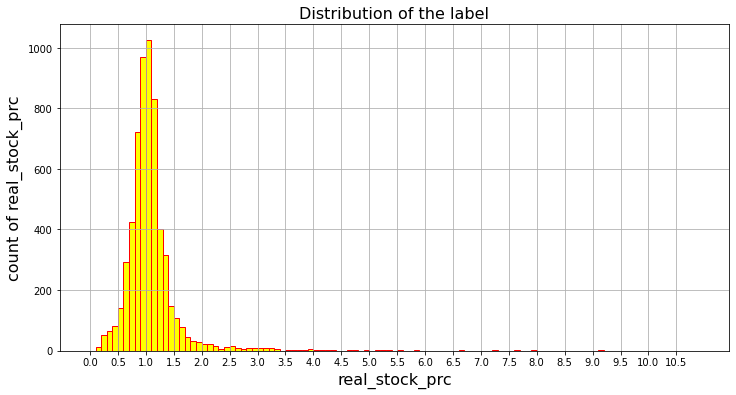

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 6))

x = labeled_df["real_stock_prc"]
bins=np.arange(0, 11, 0.1)
plt.hist(x, bins=bins, edgecolor="red", color="yellow")
plt.grid(True)
plt.title("Distribution of the label", fontsize=16)
plt.xlabel('real_stock_prc', fontsize=16)
ax.set_xticks(np.arange(0, 11, 0.5))
plt.ylabel('count of real_stock_prc',fontsize=16)
plt.show()

In [ ]:
labeled_df[["real_stock_prc"]].describe()

,real_stock_prc
count,5964.000000
mean,1.080257
std,0.520723
min,0.100000
25%,0.860000
50%,1.020000
75%,1.180000
max,11.350000


In [ ]:
#Create bins of for real_stock_prc to check count of destribution
bins = pd.cut(labeled_df["real_stock_prc"], np.arange(0, 2, 0.1))
grouped_df  = labeled_df.groupby(bins)["real_stock_prc"].agg(count='count')
grouped_df

,count
real_stock_prc,
"(0.0, 0.1]",2
"(0.1, 0.2]",10
"(0.2, 0.3]",49
"(0.3, 0.4]",73
"(0.4, 0.5]",87
"(0.5, 0.6]",129
"(0.6, 0.7]",293
"(0.7, 0.8]",480
"(0.8, 0.9]",753


### Set label for dataframe

In [ ]:
#total rows 5964 / 811 -> 13,60 %
label_df = labeled_df[labeled_df['real_stock_prc'] < 0.75]
label_df

,Symbol,url,date_filed,date_until_next_filing_1,stockprice_after_filed,stockprice_before_next_filing,indexprice_after_filed,indexprice_before_next_filing,stockprice_prc,indexprice_prc,real_stock_prc
2012,'AAL',https://www.sec.gov/Archives/edgar/data/6201/0...,2018-02-21,2019-02-25,5.324000e+01,3.498000e+01,2731.260010,2781.580078,0.66,1.02,0.65
1522,'AAL',https://www.sec.gov/Archives/edgar/data/6201/0...,2019-02-25,2020-02-19,3.575000e+01,2.914000e+01,2803.120117,3380.689941,0.82,1.21,0.68
1027,'AAL',https://www.sec.gov/Archives/edgar/data/6201/0...,2020-02-19,2021-02-17,2.890000e+01,1.749000e+01,3341.020020,3905.780029,0.61,1.17,0.52
6107,'AAP',https://www.sec.gov/Archives/edgar/data/115844...,2009-03-04,2010-03-02,3.719000e+01,4.080000e+01,708.270020,1107.239990,1.10,1.56,0.71
3884,'AAP',https://www.sec.gov/Archives/edgar/data/115844...,2014-02-25,2015-03-03,1.105500e+06,7.185000e+05,1852.650024,2112.739990,0.65,1.14,0.57
...,...,...,...,...,...,...,...,...,...,...,...
994,'ZBH',https://www.sec.gov/Archives/edgar/data/113686...,2021-02-22,2022-02-25,1.558252e+02,1.183398e+02,3881.370117,4225.500000,0.76,1.09,0.70
4326,'ZBRA',https://www.sec.gov/Archives/edgar/data/877212...,2014-02-20,2015-03-17,8.061000e+05,5.323000e+05,1846.130005,2064.560059,0.66,1.12,0.59
6530,'ZION',https://www.sec.gov/Archives/edgar/data/109380...,2009-02-27,2010-03-01,5.502400e+06,4.482200e+06,729.570007,1101.239990,0.81,1.51,0.54
995,'ZION',https://www.sec.gov/Archives/edgar/data/109380...,2021-02-25,2022-02-25,1.710500e+06,1.148800e+06,3839.659912,4324.930176,0.67,1.13,0.59


In [ ]:
def label(value):
    if value < 0.75:
        return "low_performance"
    if value >= 0.75:
        return "performance"
 
labeled_df['label'] = labeled_df['real_stock_prc'].map(label)
labeled_df.head()

,Symbol,url,date_filed,date_until_next_filing_1,stockprice_after_filed,stockprice_before_next_filing,indexprice_after_filed,indexprice_before_next_filing,stockprice_prc,indexprice_prc,real_stock_prc,label
5676,'A',https://www.sec.gov/Archives/edgar/data/109087...,2009-12-21,2010-12-20,21.587982,28.426323,3.641130e+09,4.736820e+09,1.32,1.30,1.02,performance
5236,'A',https://www.sec.gov/Archives/edgar/data/109087...,2010-12-20,2011-12-16,28.984262,23.254648,1.255820e+03,1.225730e+03,0.80,0.98,0.82,performance
4793,'A',https://www.sec.gov/Archives/edgar/data/109087...,2011-12-16,2012-12-20,24.284693,29.856937,1.219740e+03,1.430470e+03,1.23,1.17,1.05,performance
4343,'A',https://www.sec.gov/Archives/edgar/data/109087...,2012-12-20,2013-12-19,29.363377,40.321888,1.443670e+03,1.786470e+03,1.37,1.24,1.10,performance
3887,'A',https://www.sec.gov/Archives/edgar/data/109087...,2013-12-19,2014-12-22,40.708157,40.110001,1.810250e+03,2.018980e+03,0.99,1.12,0.88,performance


### Parse text items

#### Load df

The dataset was slit into sections and the items were extracted separately, to avoid crashing of the notebook

In [ ]:
labeled_df = pd.read_csv(data_path+"data/labeled_df.csv", index_col=0)

In [ ]:
labeled_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5964 entries, 5676 to 996
Data columns (total 12 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Symbol                         5964 non-null   object 
 1   url                            5964 non-null   object 
 2   date_filed                     5964 non-null   object 
 3   date_until_next_filing_1       5964 non-null   object 
 4   stockprice_after_filed         5964 non-null   float64
 5   stockprice_before_next_filing  5964 non-null   float64
 6   indexprice_after_filed         5964 non-null   float64
 7   indexprice_before_next_filing  5964 non-null   float64
 8   stockprice_prc                 5964 non-null   float64
 9   indexprice_prc                 5964 non-null   float64
 10  real_stock_prc                 5964 non-null   float64
 11  label                          5964 non-null   object 
dtypes: float64(7), object(5)
memory usage: 605.7+ 

In [ ]:
#only keep columns of interest
labeled_df_1 = labeled_df[["Symbol","url","date_filed","label"]] 
labeled_df_1.head(1)

,Symbol,url,date_filed,label
5676,'A',https://www.sec.gov/Archives/edgar/data/109087...,2009-12-21,performance


In [ ]:
label_df_2 = labeled_df_1.iloc[4000:]
label_df_2.head(1)

,Symbol,url,date_filed,label
3261,'NUE',https://www.sec.gov/Archives/edgar/data/73309/...,2016-02-26,performance


#### Item 1A

In [ ]:
item1_list = []
#((Item|ITEM)(\s|&#160;|&nbsp;)(1A)(RISK|Risk) (.*?) (Item|ITEM)(\s|&#160;|&nbsp;)(1B|2)(UNRESOLVED|Unresolved)
#((Item.{1,5})?\b1A\b.{1,5}Risk.{1,5}Factors ) (.*?) ((Item.{1,5})?\b1B\b.{1,5}Unresolved)
item1_regex = re.compile(r"(Item.{1,7})?\b1A\b.{1,5}Risk.{1,5}Factors",  re. IGNORECASE | re.DOTALL)
item2_regex = re.compile(r"( (Item.{1,7})?\b1B\b.{1,5}Unresolved) | ((Item.{1,7})?\b2\b.{1,5}Properties)",  re. IGNORECASE | re.DOTALL)


for url in label_df_2["url"]:
 # request = requests.get(url, headers=headers)
  with requests.get(url, headers=headers, stream=True) as r:

    try:
      soup = BeautifulSoup(r.content,'lxml')     #soup = BeautifulSoup(request.text,'html.parser')     
      text = soup.find('text').extract().text
      text = text.strip()
      while '  ' in text:                #remove extra spaces 
        text = text.replace('  ', ' ')
      text = text.split()[2000:]        #remove table of content, first 2000 words
      text = " ".join(text)

      #find position of Item 1 heading
      start_match = item1_regex.search(text)
      min_length = 500    # min length of text section
      #if there is a match
      if start_match!="":   
        #save the text position of Item 1 heading, start() returns the position of the match 
        start_pos = start_match.start()
        #find the position of Item 1B/2 heading; start search after Item 1 heading position
        end_pos = start_pos
        #find Item Item 1B/2 heading that is at least min_length characters further from the start postion
        while (end_pos < start_pos + min_length) and end_pos != -1: 
            end_match = item2_regex.search(text ,end_pos + 1)
        #if successful, set end_pos to the position of match
            if end_match:
              end_pos = end_match.start()
        #if there is no match, set end_pos to -1
            else:
              end_pos = -1
        #extract text
        if end_pos > 0:
          item1_text = text[start_pos:end_pos]
          #add to list
          item1_list.append(item1_text)
        else:
          error_1 = "endpos_error"
          item1_list.append(error_1) 

      else:
          error_2 = "startpos_error"
          item1_list.append(error_2) 

    except:
      error_3 = "regex_error"
      item1_list.append(error_3)            

#add to dataframe
label_df_2["risk_factors"] = item1_list

#save data
path = '/content/drive/MyDrive/Masterthesis/data/item1_parsed/parsed_tail.csv'
with open(path, 'w', encoding = 'utf-8-sig') as f:
  label_df_2.to_csv(f)

NameError: ignored

In [ ]:
label_df_2.head()

#### Item 7 + 7A

In [ ]:
item7_list = []

item6_regex = re.compile(r"(Item.{1,7})?\b6\b.{1,5}Selected.{1,5}Financial.{1,5}Data",  re. IGNORECASE | re.DOTALL)
item7_regex = re.compile(r"(Item.{1,7})?\b7\b.{1,15}Discussion.{1,5}and.{1,5}Analysis",  re. IGNORECASE | re.DOTALL)
#item8_regex = re.compile(r"( (Item.{1,7})?\b8\b.{1,5}Financial.{1,5}Statements.{1,5}and.{1,5}Supplementary)",  re. IGNORECASE | re.DOTALL)
item8_regex = re.compile(r"(Item.{1,7})?\b8\b.{1,15}Financial.{1,5}Statements.{1,5}and.{1,5}Supplementary", re. IGNORECASE | re.DOTALL)
#item7A_regex = re.compile(r"(Item.{1,7})?\b7A\b.{1,5}Quantitative.{1,5}and.{1,5}Qualitative",  re. IGNORECASE | re.DOTALL)



for url in label_df_2["url"]:
 # request = requests.get(url, headers=headers)
  with requests.get(url, headers=headers, stream=True) as r:

    try:
      soup = BeautifulSoup(r.content,'lxml')     #soup = BeautifulSoup(request.text,'html.parser')     
      text = soup.find('text').extract().text
      text = text.strip()
      while '  ' in text:                #remove extra spaces 
        text = text.replace('  ', ' ')
      text = text.split()[5000:]        #remove table of content, first 6000 words
      text = " ".join(text)

      #find position of Item 6 heading
      start_match_6 = item6_regex.search(text)
      #print(start_match_6)
      min_length = 500    # min length of text section
      #if there is a match
      if start_match_6!="":   
        #save the text position of Item 6 heading, start() returns the position of the match 
        start_pos_6 = start_match_6.start()
        #print(start_pos_6)
        #find the position of Item 7 heading; start search after Item 6 heading position        
        start_match_7 = item7_regex.search(text,start_pos_6)
        #print(start_match_7)
        start_pos_7 = start_match_7.start()
        end_pos = start_pos_7

        #find Item Item 8 heading that is at least min_length characters further from the start postion
        while (end_pos < start_pos_7 + min_length) and end_pos != -1: 
            end_match = item8_regex.search(text ,end_pos + 1)
        #if successful, set end_pos to the position of match
            if end_match:
              end_pos = end_match.start()
        #if there is no match, set end_pos to -1
            else:
              end_pos = -1
        #extract text
        if end_pos > 0:
          item7_text = text[start_pos_7:end_pos]
          #add to list
          item7_list.append(item7_text)
        else:
          error_1 = "endpos_error"
          item7_list.append(error_1) 

      else:
          error_2 = "startpos_error"
          item7_list.append(error_2) 

    except:
      error_3 = "regex_error"
      item7_list.append(error_3)            

#add to dataframe
label_df_2["section7"] = item7_list

#save data
path = '/content/drive/MyDrive/Masterthesis/data/item7_parsed/parsedtail.csv'
with open(path, 'w', encoding = 'utf-8-sig') as f:
  label_df_2.to_csv(f)

<ipython-input-27-abaacbc9f779>:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  label_df_2["section7"] = item7_list


In [ ]:
label_df_2

,Symbol,url,date_filed,label,section7
2074,'CBRE',https://www.sec.gov/Archives/edgar/data/113811...,2018-03-01,performance,Item 7. Management’s Discussion and Analysis o...
1585,'CBRE',https://www.sec.gov/Archives/edgar/data/113811...,2019-03-01,performance,Item 7. Management’s Discussion and Analysis o...
1090,'CBRE',https://www.sec.gov/Archives/edgar/data/113811...,2020-03-02,performance,Item 7. Management’s Discussion and Analysis o...
594,'CBRE',https://www.sec.gov/Archives/edgar/data/113811...,2021-02-24,performance,Item 7. Management’s Discussion and Analysis o...
6215,'CCI',https://www.sec.gov/Archives/edgar/data/105147...,2009-02-26,low_performance,Item 7. Managements Discussion and Analysis o...
...,...,...,...,...,...
1668,'ESS',https://www.sec.gov/Archives/edgar/data/920522...,2019-02-21,performance,Item 7. Management’s Discussion and Analysis o...
1175,'ESS',https://www.sec.gov/Archives/edgar/data/920522...,2020-02-20,low_performance,Item 7.Management's Discussion and Analysis of...
679,'ESS',https://www.sec.gov/Archives/edgar/data/920522...,2021-02-19,low_performance,Item 7. Management’s Discussion and Analysis o...
4474,'ETN',https://www.sec.gov/Archives/edgar/data/155118...,2013-02-28,performance,regex_error


#### backlog

In [ ]:
item7_list = []

item6_regex = re.compile(r"(Item.{1,7})?\b6\b.{1,5}Selected.{1,5}Financial.{1,5}Data",  re. IGNORECASE | re.DOTALL)
item7_regex = re.compile(r"(Item.{1,7})?\b7\b.{1,15}Discussion.{1,5}and.{1,5}Analysis",  re. IGNORECASE | re.DOTALL)
#item8_regex = re.compile(r"( (Item.{1,7})?\b8\b.{1,5}Financial.{1,5}Statements.{1,5}and.{1,5}Supplementary)",  re. IGNORECASE | re.DOTALL)
item8_regex = re.compile(r"(Item.{1,7})?\b8\b.{1,15}Financial.{1,5}Statements.{1,5}and.{1,5}Supplementary", re. IGNORECASE | re.DOTALL)
item7a_regex = re.compile(r"(Item.{1,7})?\b7A\b.{1,5}Quantitative.{1,5}and.{1,5}Qualitative",  re. IGNORECASE | re.DOTALL)



for url in label_df_2["url"]:
 # request = requests.get(url, headers=headers)
  with requests.get(url, headers=headers, stream=True) as r:

    try:
      soup = BeautifulSoup(r.content,'lxml')     #soup = BeautifulSoup(request.text,'html.parser')     
      text = soup.find('text').extract().text
      text = text.strip()
      while '  ' in text:                #remove extra spaces 
        text = text.replace('  ', ' ')
      text = text.split()[5000:]        #remove table of content, first 6000 words
      text = " ".join(text)

      #find position of Item 6 heading
      start_match_6 = item6_regex.search(text)
      #print(start_match_6)
      min_length = 500    # min length of text section
      #if there is a match
      if start_match_6!="":   
        #save the text position of Item 6 heading, start() returns the position of the match 
        start_pos_6 = start_match_6.start()
        #print(start_pos_6)
        #find the position of Item 7 heading; start search after Item 6 heading position        
        start_match_7 = item7_regex.search(text,start_pos_6)
        #print(start_match_7)
        start_pos_7 = start_match_7.start()
        #find position of 7A 
        start_match_7a = item7a_regex.search(text,start_pos_7)
        start_pos_7a = start_match_7a.start()
        end_pos = start_pos_7a

        #find Item Item 8 heading that is at least min_length characters further from the start postion (7A)
        while (end_pos < start_pos_7a + min_length) and end_pos != -1: 
            end_match = item8_regex.search(text ,end_pos + 1)
        #if successful, set end_pos to the position of match
            if end_match:
              end_pos = end_match.start()
        #if there is no match, set end_pos to -1
            else:
              end_pos = -1
        #extract text
        if end_pos > 0:
          item7_text = text[start_pos_7:end_pos]
          item7_list.append(item7_text)
        else:
          error_1 = "endpos_error"
          item7_list.append(error_1) 

      else:
          error_2 = "startpos_error"
          item7_list.append(error_2) 

    except:
      error_3 = "regex_error"
      item7_list.append(error_3)            

#add to dataframe
label_df_2["section7"] = item7_list

#save data
path = '/content/drive/MyDrive/Masterthesis/data/item7_parsed/parsed1000_xxx.csv'
with open(path, 'w', encoding = 'utf-8-sig') as f:
  label_df_2.to_csv(f)

<ipython-input-16-044105712261>:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  label_df_2["section7"] = item7_list


In [ ]:
item7_list = []
#url = ["https://www.sec.gov/Archives/edgar/data/1467373/000146737312000170/0001467373-12-000170.txt", "https://www.sec.gov/Archives/edgar/data/947484/000094748418000012/0000947484-18-000012.txt"]

for url in label_df_2["url"]:
  request = requests.get(url, headers=headers)
  soup = BeautifulSoup(request.content,'lxml')

  for filing_document in soup.find_all('document'):       #document_type tag contains the filing type 
    doc_type = filing_document.type.find(text=True, recursive=False).strip()

    if doc_type == "10-K":  #find 10-K tag
                          
      text_10k = filing_document.find('text').extract().text    #store 10K text
      #text_10k = text_10k[100000:]
      #regex_section = re.compile(r'(item(7[\.\s]|8|8A|8[\.\s])|'              #regex for searching the text section      #ITEM&#160;7   #ITEM&#160;8A.&#160
      #                    'discussion\sand\sanalysis\sof\s(consolidated\sfinancial|financial)\scondition|'
      #                    '(consolidated\sfinancial|financial)\sstatements\sand\ssupplementary\sdata)', re.IGNORECASE)

      regex_section = re.compile(r'(item\s(7[\.\s]).{1,20}discussion\sand\sanalysis\sof\s(consolidated\sfinancial|financial)\scondition)|'
                                  '(item\s(8[\.\s|A]).{1,20}(consolidated\sfinancial|financial)\sstatements\sand\ssupplementary\sdata)', re.IGNORECASE)
      
                                      
      try:

        array = pd.DataFrame([(match.group(), match.start()) for match in regex_section.finditer(text_10k)]) #create an array with the regex matches
        
        array.columns = ['SearchTerm', 'Start']  #set columns in array

        Rows = array['SearchTerm'].count()   #get number of rows in array
          
        #Add column in array called 'Selection' and add adjacent 'SearchTerm' (i and i+1 rows) text concatenated
        count = 0 #count for row location and iteration
        while count < (Rows-1): #only iterate to the second last row
            array.at[count,'Selection'] = (array.iloc[count,0] + array.iloc[count+1,0]).lower()
            count += 1
        
        #set up item 7 + 8 regex to check array
        regex_item7 = re.compile(r'(item\s(7[\.\s]).{1,15}discussion\s[a-z]*)')
        regex_item8 = re.compile(r'(item\s(8[\.\s|A]).{1,40}supplementary\s[a-z]*)')

            
        # Lists to store the locations of Item 7/8 Search Pattern matches
        Start_Loc = []
        End_Loc = []
            
        #Find and store the locations of Item 7/8 regex matches
        count = 0 # Set up counter
        
        while count < (Rows-1): #only iterate to second last row
            
            #Match Item 7 regex 
            if re.match(regex_item7, array.at[count,'Selection']):
                # Column 1 = 'Start' columnn in 'array'
                Start_Loc.append(array.iloc[count,1]) # Store in list => Item 7 will be the starting location (column '1' = 'Start' column)
            
            #Match Item 8 regex
            if re.match(regex_item8, array.at[count,'Selection']):
                End_Loc.append(array.iloc[count,1])

   #         print(array)
    #        array =  array.dropna()
            
            count += 1 

        item7 = text_10k[Start_Loc[-2]:End_Loc[1]]     #Extract section with start und end regex location
        item7_list.append(item7)
        print(item7[:1000])

      except:
        error = "regex_error"
        item7_list.append(error)            


label_df_2["item_7_7a"] = item7_list

<ipython-input-165-e64c6cb1f81a>:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  label_df_2["item_7_7a"] = item7_list


In [ ]:
# a regex to identify the location of Item 7 (MD&A) heading # re.DOTALL flag allows . character to match new line
# characters; needed for case when heading titles span multiple lines
item7_regex = re.compile(r'(ITEM\s+7[^A]\.?)|(DISCUSSION)',flags =re.I)

# MD&A is typically followed by Item 8, "Financial Statements and Supplementary Data"
# However, sometimes it is followed by "Summary of Selected # Financial Data" section
item8_regex = re.compile(r'(ITEM\s+8\.?)|(SUPPLEMENTARY DATA)',flags =re.I)

In [ ]:
item7_regex = re.compile(r"(item\s(7[\.\s]).{1,20}discussion\sand\sanalysis\sof\s(consolidated\sfinancial|financial)\scondition)", re. IGNORECASE | re.DOTALL)
item8_regex = re.compile(r"(item\s(8[\.\s]).{1,20}(consolidated\sfinancial|financial)\sstatements\sand\ssupplementary\sdata)", re. IGNORECASE | re.DOTALL)

In [ ]:
item7_regex = re.compile(r"(item\s(7[\.\s]).{1,10}management.{1,5}discussion.{1,5}analysis)", re. IGNORECASE | re.DOTALL)
item8_regex = re.compile(r"(item\s(8[\.\s|A|A\.]).{1,10}(financial.{1,5}statements.{1,5}supplement.{1,5}data| summary.{1,5}selected.{1,5}financial.{1,5}data))", re. IGNORECASE | re.DOTALL)

In [ ]:
item7_regex = re.compile(r"(item.{1,5})?\b7\b.{1,5}management.{1,5}discussion.{1,5}analysis", 
                         re.IGNORECASE | re.DOTALL)
item8_regex = re.compile(r"(item.{1,5})?\b8\b.{1,5}(financial.{1,5}statements.{1,5}supplement.{1,5}data|summary.{1,5}selected.{1,5}financial.{1,5}data)", re.IGNORECASE | re.DOTALL)

In [ ]:
item1a_list = []
item7_list = []
item7a_list = []
item_error_text = "not found"


for url in label_df_1["url"]:
  request = requests.get(url, headers=headers)

  try: 
    soup = BeautifulSoup(request.text,'html.parser')
    text = soup.find('text').extract().text
    text = text.strip()

    try:
      item1a_result = re.findall("(Item\s+1A\.?)(.*?)(Item\s+2)", text) 
      item1a = item1a_result[1][1]
      item1a_list.append(item1a)
        

    except:
      item1a_list.append(item_error_text)

    try:
      item7_result = re.findall("(Item\s+7)(.*?)(Item\s+7A\.?)", text) 
      item7 = item7_result[1][1]
      item7_list.append(item7)
      

    except: 
      item7_list.append(item_error_text)


    try:
      item7a_result = re.findall("(Item\s+7A\.?)(.*?)(Item\s+8\.?)", text)
      item7a = item7a_result[1][1]
      item7a_list.append(item7a)
      

    except:
      item7a_list.append(item_error_text)


  except:
    item_error_text_e = "parsing error"
    item1a_list.append(item_error_text_e)
    item7_list.append(item_error_text_e)
    item7a_list.append(item_error_text_e)


label_df_1["risk_factors"] = item1a_list
label_df_1["mdaf"] = item7_list
label_df_1["qqdmr"] = item7a_list

/usr/local/lib/python3.8/dist-packages/bs4/builder/_htmlparser.py:78: UserWarning: expected name token at '<![=.IMO$&GZQI-YJG\nM'
  warnings.warn(msg)
/usr/local/lib/python3.8/dist-packages/bs4/builder/_htmlparser.py:78: UserWarning: expected name token at "<![7,=\\V6!CVIKL?'O;M"
  warnings.warn(msg)
/usr/local/lib/python3.8/dist-packages/bs4/builder/_htmlparser.py:78: UserWarning: expected name token at '<![.D\nMP*9J@,D4N,D>%'
  warnings.warn(msg)
/usr/local/lib/python3.8/dist-packages/bs4/builder/_htmlparser.py:78: UserWarning: expected name token at '<![*U$. [ Q78@4R,H1@'
  warnings.warn(msg)
/usr/local/lib/python3.8/dist-packages/bs4/builder/_htmlparser.py:78: UserWarning: unknown status keyword 'US' in marked section
  warnings.warn(msg)
/usr/local/lib/python3.8/dist-packages/bs4/builder/_htmlparser.py:78: UserWarning: unknown status keyword 'A' in marked section
  warnings.warn(msg)
/usr/local/lib/python3.8/dist-packages/bs4/builder/_htmlparser.py:78: UserWarning: unknown status 

In [ ]:
#show the symbols where the text could be retreived
label_df_2 =  label_df_1[(label_df_1['risk_factors']!="not found") & (label_df_1['mdaf']!="not found") & (label_df_1['qqdmr']!="not found") & (label_df_1['mdaf']!="parsing error") ]


In [ ]:
label_df_2.shape

<class 'pandas.core.frame.DataFrame'>
Int64Index: 169 entries, 3807 to 996
Data columns (total 15 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Symbol                         169 non-null    object 
 1   url                            169 non-null    object 
 2   date_filed                     169 non-null    object 
 3   date_until_next_filing_1       169 non-null    object 
 4   stockprice_after_filed         169 non-null    float64
 5   stockprice_before_next_filing  169 non-null    float64
 6   indexprice_after_filed         169 non-null    float64
 7   indexprice_before_next_filing  169 non-null    float64
 8   stockprice_prc                 169 non-null    float64
 9   indexprice_prc                 169 non-null    float64
 10  real_stock_prc                 169 non-null    float64
 11  label                          169 non-null    object 
 12  risk_factors                   169 non-null    

In [ ]:
label_df_1.to_csv(r"parsed_6000.csv")

### Save dataframe

In [ ]:
with open("data_path", "a") as f:
  print(labeled_df, file=f)
  f. close()

In [ ]:
#left join of labeled_df + df in case company data is required for the evaluation
#df_merged = labeled_df.merge(df, on='Symbol', how='left', indicator=True)